In [12]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd

from IPython.display import Image

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

import warnings

import umap
from sklearn.preprocessing import StandardScaler

In [13]:
%config InlineBackend.figure_format='retina'

In [14]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device cpu


In [15]:
root = '.'
fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


# CartPole env

In [16]:
import gymnasium as gym
env = gym.make('CartPole-v1')

# Policy evaluation

In [17]:
def eval_trajectory(env, trajectory):
    
    observation, info = env.reset(seed=0)
    t = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        try:
            action = trajectory[t]
            # action = env.action_space.sample()  # agent policy that uses the observation and info
            observation, reward, terminated, truncated, info = env.step(action)
            t += 1
        except IndexError:
            break
    return t


def eval_policy(env, policy, p=None, kl_div_factor=0.001, n_sample=10):
    
    q = dist.Binomial(probs=policy)
    trajectories = q.sample((n_sample, ))
    
    loss, p_sum = 0, 0

    for traj in trajectories:

        reward = eval_trajectory(trajectory=traj.long().cpu().numpy(), env=env)

        p_traj = q.log_prob(traj).sum().exp()
        loss -= p_traj * reward
        p_sum += p_traj

    loss /= p_sum
    
    if p is not None:
        kl_div = dist.kl_divergence(q, p).sum()
        loss += kl_div_factor * kl_div
    
    return loss/len(policy)

# Dataset creation

In [18]:
class TrainDataset(Dataset): 
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        super().__init__()
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx]

In [25]:
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(1234)

n_sample_start = 1000
n_steps = 20

print("creating samples")
train_x = torch.rand(n_sample_start, n_steps).to(device)

with torch.no_grad():
    train_y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in train_x]).to(device)

# Exclude best ones
not_too_good = train_y <= 0.8
train_y = train_y[not_too_good]
train_x = train_x[not_too_good]
train_dataset = TrainDataset(train_x=train_x, train_y=train_y)

creating samples


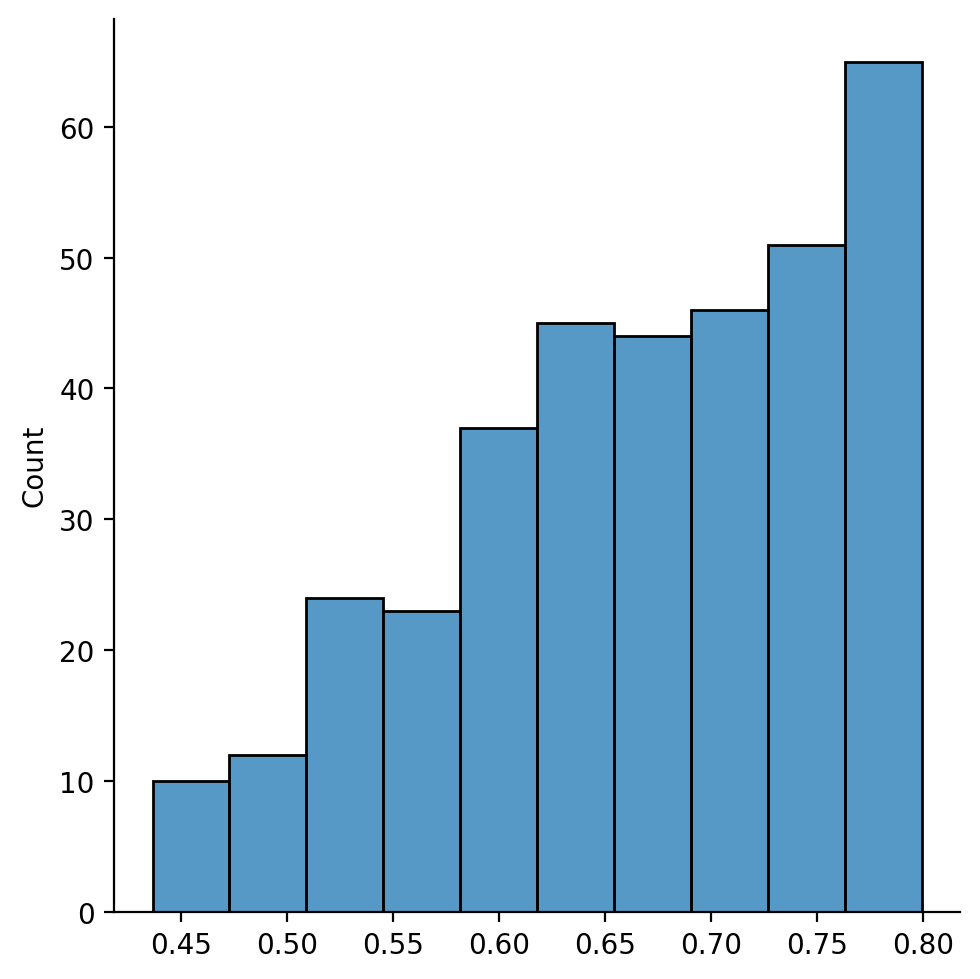

In [26]:
y = train_dataset.train_y.cpu().numpy()
sns.displot(y);

In [27]:
y.max()

0.799591

# VAE training

In [28]:
class VAE(nn.Module):
    def __init__(self, n_steps, size_z):
        super().__init__()

        self.enc1 = nn.Linear(n_steps, 40)
        self.enc2 = nn.Linear(40, 20)
        self.mu = nn.Linear(20, size_z)
        self.logvar = nn.Linear(20, size_z)
        
        self.dec1 = nn.Linear(size_z, 20)
        self.dec2 = nn.Linear(20, 40)
        self.dec3 = nn.Linear(40, n_steps)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = torch.sigmoid(self.pred3(x).squeeze())     
        return x

# Training VAE

In [39]:
size_z = 2

vae = VAE(n_steps=n_steps, size_z=size_z).to(device)
reg = Regression(size_z).to(device)

vae_learning_rate = 0.001

n_epoch_vae = 1000
batch_size_vae = 200
weight_reg_loss = 10e3 #10000  
weight_sim_loss = 0.0001

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_vae)

optimizer_vae = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=vae_learning_rate)

with tqdm(total=n_epoch_vae, leave=True) as pbar_vae:
    
    for epoch in range(n_epoch_vae):
        
        train_vae_loss, train_reg_loss, train_sim_loss = 0, 0, 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
            l_vae = bce + kl

            pred = reg(mu)
            l_reg = nn.MSELoss(reduction="sum")(target=y, input=pred)

            z_dist = torch.cdist(mu, mu)
            y_dist = torch.cdist(y.unsqueeze(1), y.unsqueeze(1))
            l_sim = - torch.matmul(y_dist, z_dist).sum()

            l_sim *= weight_sim_loss
            l_reg *= weight_reg_loss
            loss = l_sim + l_vae + l_reg
            
            loss.backward()
            optimizer_vae.step()

            train_vae_loss += l_vae.item()
            train_reg_loss += l_reg.item()
            train_sim_loss += l_sim.item()

        pbar_vae.update()
        pbar_vae.set_postfix({
            "loss VAE": f"{train_vae_loss/len(train_y):.4f}",
            "loss regression": f"{train_reg_loss/len(train_y):.4f}",
            "loss similarity": f"{train_sim_loss/len(train_y):.4f}"
        })


  0%|          | 0/1000 [00:00<?, ?it/s]

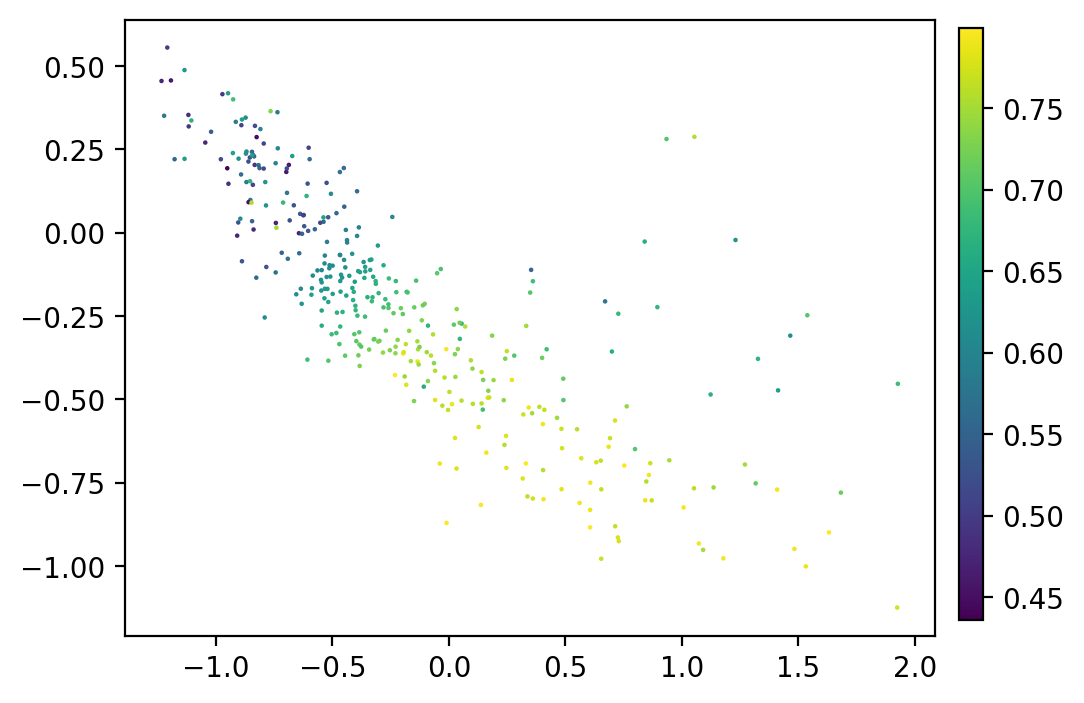

In [47]:
vae.eval()
x, y = train_dataset.train_x, train_dataset.train_y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

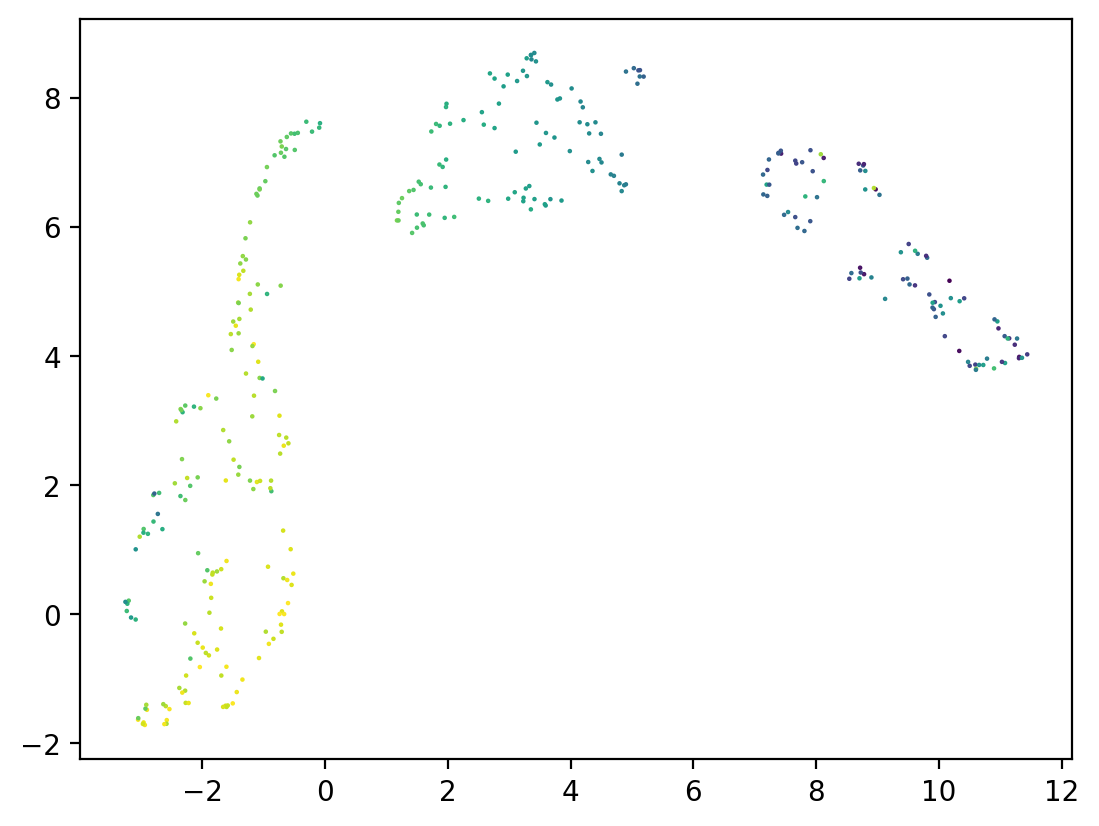

In [40]:
vae.eval()
x, y = train_dataset.train_x, train_dataset.train_y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(z)
embedding = reducer.fit_transform(scaled_data)

fig, ax = plt.subplots()
ax.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4);

# Using DNN from the latent 

In [46]:
epochs = 50
n_sample_policy = 10 

max_y = 0

with torch.no_grad():    
    z_best, _ = vae.encode(train_dataset.train_x[torch.argmax(train_dataset.train_y)])

mu = z_best
logvar = torch.zeros(len(mu)).to(device)

optimizer = optim.Adam([mu, logvar], lr=1.0)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()

        q = dist.Normal(mu, torch.exp(0.5*logvar))
        z = q.sample((n_sample_policy, )).to(device)
        x = vae.decode(z)
        
        loss = 0
        for i in range(n_sample_policy):
            zi, xi = z[i], x[i]
            obs = eval_policy(env=env, policy=xi, p=None)
            logq_zi = q.log_prob(zi).sum()
            loss_i = obs*logq_zi
            loss += loss_i

            max_y = max(max_y, - obs.detach().item())

        if epoch == 0:
            print("Max y at start", max_y)
        
        loss.backward()
        optimizer.step()
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{max_y:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Max y at start 0.9719999432563782


In [43]:
q = dist.Normal(mu, torch.exp(0.5*logvar))
z = q.sample((n_sample_policy, )).to(device)
x = vae.decode(z)

obs = 0
for i in range(n_sample_policy):
    zi, xi = z[i], x[i]
    obs -= eval_policy(env=env, policy=xi, p=None)

print("After training", obs/n_sample_policy)

After training tensor(0.6915, grad_fn=<DivBackward0>)


# From Umap

In [48]:
with torch.no_grad():    
    z_best, _ = vae.encode(train_dataset.train_x[torch.argmax(train_dataset.train_y)])

dm_init_value = torch.from_numpy(reducer.transform(z_best.cpu().numpy().reshape(1, -1))).squeeze()

hist_y = []

epochs = 5000

mu = dm_init_value
logvar = torch.zeros(len(mu))

optimizer = optim.Adam([mu, logvar], lr=0.01)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()

        q = dist.Normal(mu, torch.exp(0.5*logvar))
        z2 = q.sample((10, ))
        z = torch.from_numpy(reducer.inverse_transform(z2.detach().cpu().numpy())).to(device)
        x = vae.decode(z)
        loss = 0
        for z2_i, x_i in zip(z2, x):
            obs = eval_policy(env=env, policy=x_i, p=None).to(device)
            q_z2_i = q.log_prob(z2_i).to(device).sum().exp()
            loss_i = obs*q_z2_i
            loss += loss_i

            hist_y.append(- obs.detach().item())
        
        loss.backward()
        optimizer.step()
        
        best_value = np.max(hist_y) 
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{best_value:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Using GP after VAE trained

In [45]:
# Remove warnings
warnings.filterwarnings("ignore")

dtype=torch.float

acq_opt__batch_size = 3
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 13537

n_batch = 10

n_sample_start = 10


best_observed = []
cand_observed = []
val_observed = []

# Create a small dataset from the dataset the VAE has been trained with
best = torch.topk(train_dataset.train_y, k=n_sample_start).indices
train_x = train_dataset.train_x[best]
train_y = train_dataset.train_y[best]
with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.train_x[best])

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        model = SingleTaskGP(train_X=train_z, train_Y=train_y.unsqueeze(dim=1))
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed
        )
        qEI = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())

        # optimize and get new observation
        # optimize
        bounds = torch.zeros((2, size_z)).to(device)
        bounds[0, :] = - 4
        bounds[1, :] = 4
        candidates, _ = optimize_acqf(
            acq_function=qEI,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = candidates.detach()
            new_x = vae.decode(new_z)
            new_y = torch.tensor([
                - eval_policy(
                    env=env,
                    policy=pol) for pol in new_x]).to(device)

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        cand_observed.append([cand.cpu().numpy().tolist() for cand in candidates])
        val_observed.append([val.item() for val in new_y])

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

  0%|          | 0/10 [00:00<?, ?it/s]

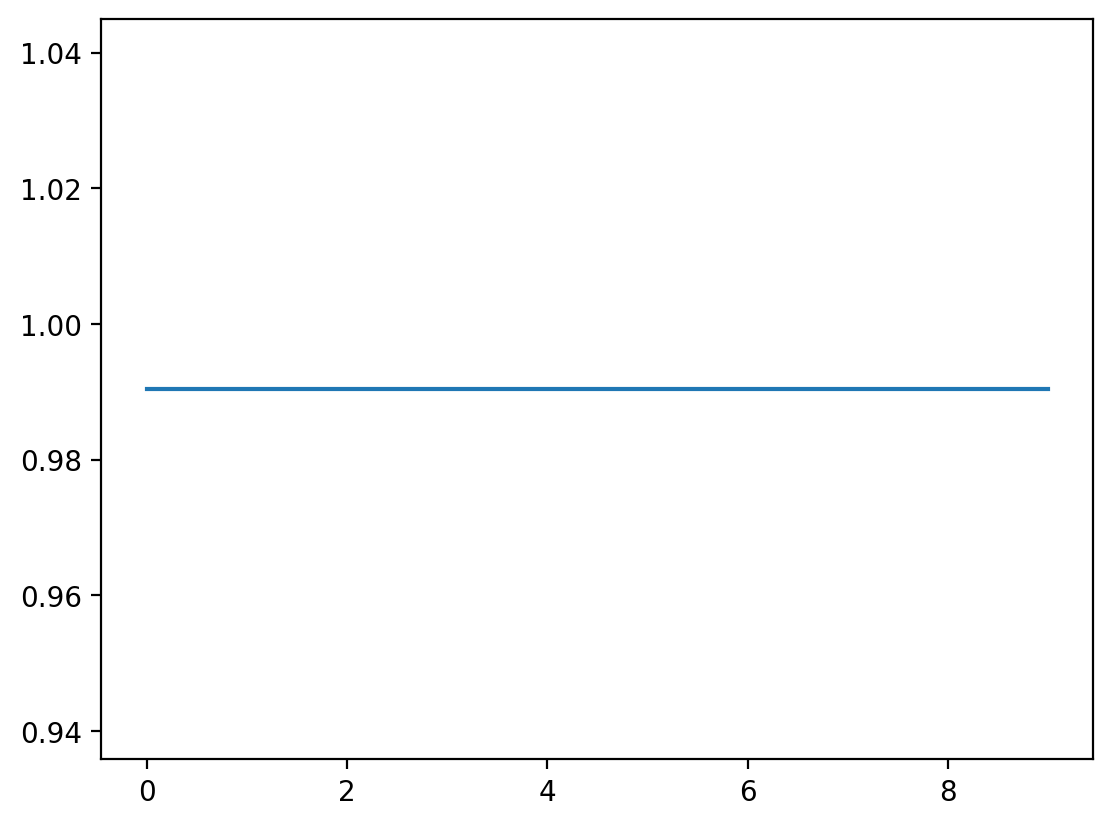

In [38]:
fig, ax = plt.subplots()
ax.plot(best_observed);

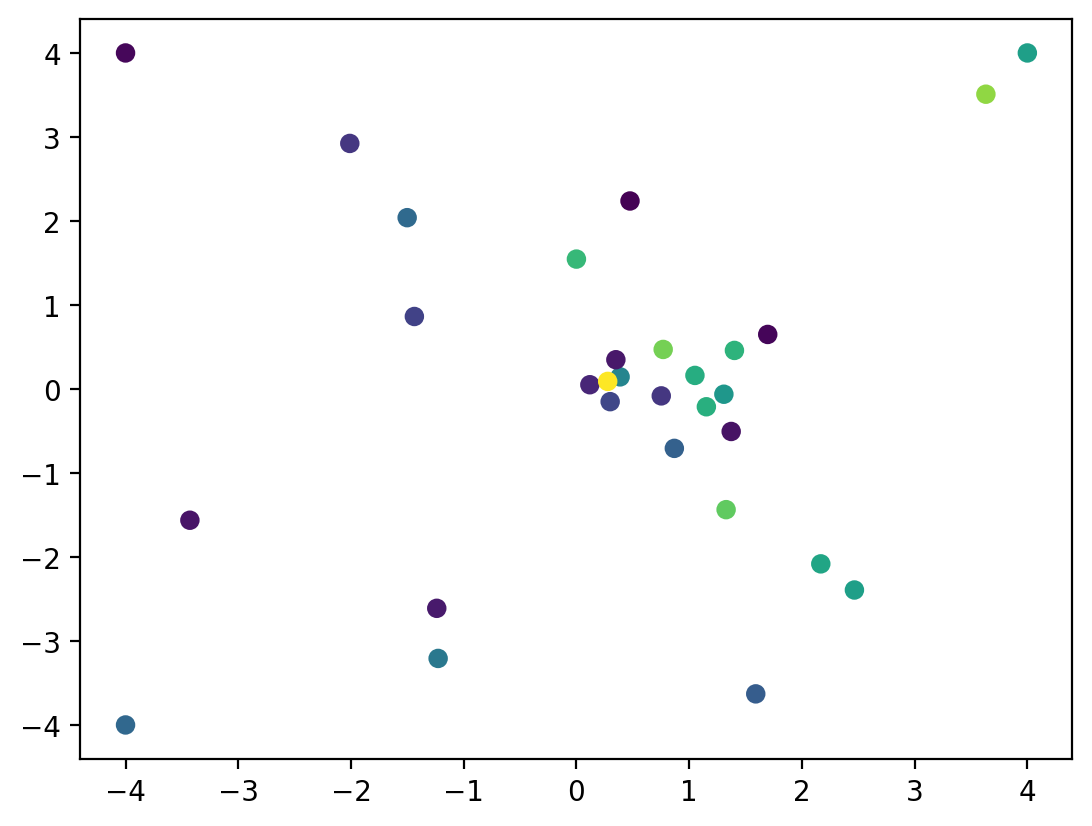

In [39]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed)
plt.scatter(x=cand_observed[:, :, 0], y=cand_observed[:, :, 1], c=val_observed,  cmap="viridis");

In [41]:
val_observed.max()

0.6492233872413635